# NYU CUSP Hackday 11/19/2016
## Spatial Data Analysis 
## Exploratory spatial data analysis of NYC Yellow Cab tipping data using shapely and geopandas

In [ ]:
## Author =  ""

## Import initial libraries

In [352]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pylab as plt
import pysal as ps
import shapely

In [353]:
np.random.seed(123) # for reproducibility

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

## Load Yellow Cab data on 2016-01

In [346]:
taxi_data=DataFrame.from_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv")
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
VendorID,,,,,,,,,,,,,,,,,,
2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


## Let's take the credit card transactions only, which provides us complete tip amount.

In [347]:
data1_new = taxi_data[df_bike_monthly.payment_type ==1] # 1 means credit card
data1_new.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
VendorID,,,,,,,,,,,,,,,,,,
2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.00,0.0,0.3,19.30
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.00,0.0,0.3,34.30
2,2016-01-01 00:00:03,2016-01-01 00:15:49,6,2.43,-73.969330,40.763538,1,N,-73.995689,40.744251,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29
1,2016-01-01 00:00:04,2016-01-01 00:14:32,1,3.70,-74.004303,40.742241,1,N,-74.007362,40.706936,1,14.0,0.5,0.5,3.05,0.0,0.3,18.35
1,2016-01-01 00:00:05,2016-01-01 00:14:27,2,2.20,-73.991997,40.718578,1,N,-74.005135,40.739944,1,11.0,0.5,0.5,1.50,0.0,0.3,13.80


In [12]:
data1_new['lonlat']=zip(data1_new.dropoff_longitude,data1_new.dropoff_latitude)
data1_new['geometry']=data1_new[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
data1_new.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,lonlat,geometry
VendorID,,,,,,,,,,,,,,,,,,,,
2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.00,0.0,0.3,19.30,"(-73.9444732666, 40.7166786194)",POINT (-73.94447326660156 40.71667861938477)
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.00,0.0,0.3,34.30,"(-73.9502716064, 40.7889251709)",POINT (-73.95027160644531 40.78892517089844)
2,2016-01-01 00:00:03,2016-01-01 00:15:49,6,2.43,-73.969330,40.763538,1,N,-73.995689,40.744251,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29,"(-73.9956893921, 40.7442512512)",POINT (-73.99568939208984 40.7442512512207)
1,2016-01-01 00:00:04,2016-01-01 00:14:32,1,3.70,-74.004303,40.742241,1,N,-74.007362,40.706936,1,14.0,0.5,0.5,3.05,0.0,0.3,18.35,"(-74.0073623657, 40.7069358826)",POINT (-74.00736236572266 40.70693588256836)
1,2016-01-01 00:00:05,2016-01-01 00:14:27,2,2.20,-73.991997,40.718578,1,N,-74.005135,40.739944,1,11.0,0.5,0.5,1.50,0.0,0.3,13.80,"(-74.0051345825, 40.739944458)",POINT (-74.00513458251955 40.73994445800781)


In [13]:
tax1_tip = data1_new.iloc[:,(11,14,-3,-1)] 

In [14]:
tax1_tip.reset_index(0,inplace = True)

In [15]:
tax1_tip.head()

,VendorID,fare_amount,tip_amount,total_amount,geometry
0,2,18.0,0.00,19.30,POINT (-73.94447326660156 40.71667861938477)
1,2,33.0,0.00,34.30,POINT (-73.95027160644531 40.78892517089844)
2,2,12.0,3.99,17.29,POINT (-73.99568939208984 40.7442512512207)
3,1,14.0,3.05,18.35,POINT (-74.00736236572266 40.70693588256836)
4,1,11.0,1.50,13.80,POINT (-74.00513458251955 40.73994445800781)


In [16]:
tax1_tip["tip_percentage"] =  100*tax1_tip["tip_amount"]/tax1_tip["fare_amount"]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
len(tax1_tip)

7181476

In [343]:
tax1_tip.head()

,VendorID,fare_amount,tip_amount,total_amount,geometry,tip_percentage
0,2,18.0,0.00,19.30,POINT (-73.94447326660156 40.71667861938477),0.000000
1,2,33.0,0.00,34.30,POINT (-73.95027160644531 40.78892517089844),0.000000
2,2,12.0,3.99,17.29,POINT (-73.99568939208984 40.7442512512207),33.250000
3,1,14.0,3.05,18.35,POINT (-74.00736236572266 40.70693588256836),21.785714
4,1,11.0,1.50,13.80,POINT (-74.00513458251955 40.73994445800781),13.636364


## Map  Tip_percentage to CT level

### Intersect the two geometries

In [348]:
ct_shape.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


## Let's take random 10000 numbers

In [354]:
taxi2 = np.random.choice(tax1_tip.index,10000, replace=True)


In [355]:
tax1_rand = tax1_tip.iloc[taxi2,:]

In [356]:
tax1_rand.head()

,VendorID,fare_amount,tip_amount,total_amount,geometry,tip_percentage
4967934,2,9.0,2.06,12.36,POINT (-73.95562744140625 40.76935958862305),22.888889
277869,2,19.0,3.00,22.80,POINT (-73.98857879638672 40.74804306030273),15.789474
4222334,2,7.0,1.56,9.36,POINT (-73.98845672607422 40.73218154907227),22.285714
3163458,1,17.0,3.75,22.55,POINT (-73.97713470458984 40.76444625854492),22.058824
1241052,1,7.5,1.65,9.95,POINT (-73.95912170410156 40.77190780639648),22.000000


In [357]:
len(tax1_rand)

10000

In [358]:
tax1_rand.index = range(10000)

In [359]:
tax1_rand.head()

,VendorID,fare_amount,tip_amount,total_amount,geometry,tip_percentage
0,2,9.0,2.06,12.36,POINT (-73.95562744140625 40.76935958862305),22.888889
1,2,19.0,3.00,22.80,POINT (-73.98857879638672 40.74804306030273),15.789474
2,2,7.0,1.56,9.36,POINT (-73.98845672607422 40.73218154907227),22.285714
3,1,17.0,3.75,22.55,POINT (-73.97713470458984 40.76444625854492),22.058824
4,1,7.5,1.65,9.95,POINT (-73.95912170410156 40.77190780639648),22.000000


In [360]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(tax1_rand)):
    a.append(ct_shape[ct_shape.geometry.intersects(tax1_rand.iloc[i].geometry)].BoroCT2010.values)
    print '\r',"%",str((i+1)*100./len(tax1_rand))[:4],
tax1_rand['BoroCT2010']=a

% 100.


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
tax1_rand.BoroCT2010 = tax1_rand.BoroCT2010.apply(lambda x: str(x)[3:10])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [32]:
tipmean = tax1_rand.tip_percentage.groupby(tax1_rand.BoroCT2010).mean()

In [33]:
tipmean = pd.DataFrame(tipmean)

In [35]:
tipmean.head()

,tip_percentage
BoroCT2010,
,20.757676
1000201,25.384615
1000202,24.107143
1000600,19.136006
1000700,19.327208


In [36]:
tipmean.reset_index(inplace = True)


In [37]:
tipmean.head()

,BoroCT2010,tip_percentage
0,,20.757676
1,1000201,25.384615
2,1000202,24.107143
3,1000600,19.136006
4,1000700,19.327208


### Add the tip average to the CT shapefile 

In [252]:
ct_shape.BoroCT2010 = ct_shape.BoroCT2010.astype(str)

In [253]:
ct_shape_tip = ct_shape.merge(tipmean, on = "BoroCT2010", how = "inner")

In [361]:
ct_shape_tip.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,tip_percentage,label
0,1002202,1,Manhattan,I,002202,22.02,MN28,Lower East Side,3809,6.039223e+05,3817.391631,POLYGON ((-73.97823073299477 40.72067428669261...,19.204650,2
1,1003200,1,Manhattan,I,003200,32,MN22,East Village,3809,2.334190e+06,6358.386684,POLYGON ((-73.97990650235904 40.72686577300233...,22.823317,3
2,1006800,1,Manhattan,I,006800,68,MN21,Gramercy,3808,1.877943e+06,5723.883037,"POLYGON ((-73.98085965412409 40.7419697680819,...",20.344389,3
3,1008900,1,Manhattan,I,008900,89,MN13,Hudson Yards-Chelsea-Flatiron-Union Square,3807,1.782279e+06,5578.769499,POLYGON ((-73.99897237419262 40.74463005524836...,22.712052,3
4,1009600,1,Manhattan,E,009600,96,MN17,Midtown-Midtown South,3807,1.887288e+06,5737.356247,"POLYGON ((-73.9776548272757 40.75791142377995,...",21.103517,3


# Using the Mean and Std to understand the tip amount

In [255]:
temp = ct_shape_tip.iloc[:,(0,-1)]
print ("The mean of the tip amount: %.2f dollars"%(temp["tip_percentage"].mean()))

The mean of the tip amount: 19.70 dollars


In [256]:
temp["tip_percentage"].std()
print ("The standard deviation of the tip amount: %.2f dollars"%(temp["tip_percentage"].std()))

The standard deviation of the tip amount: 9.84 dollars


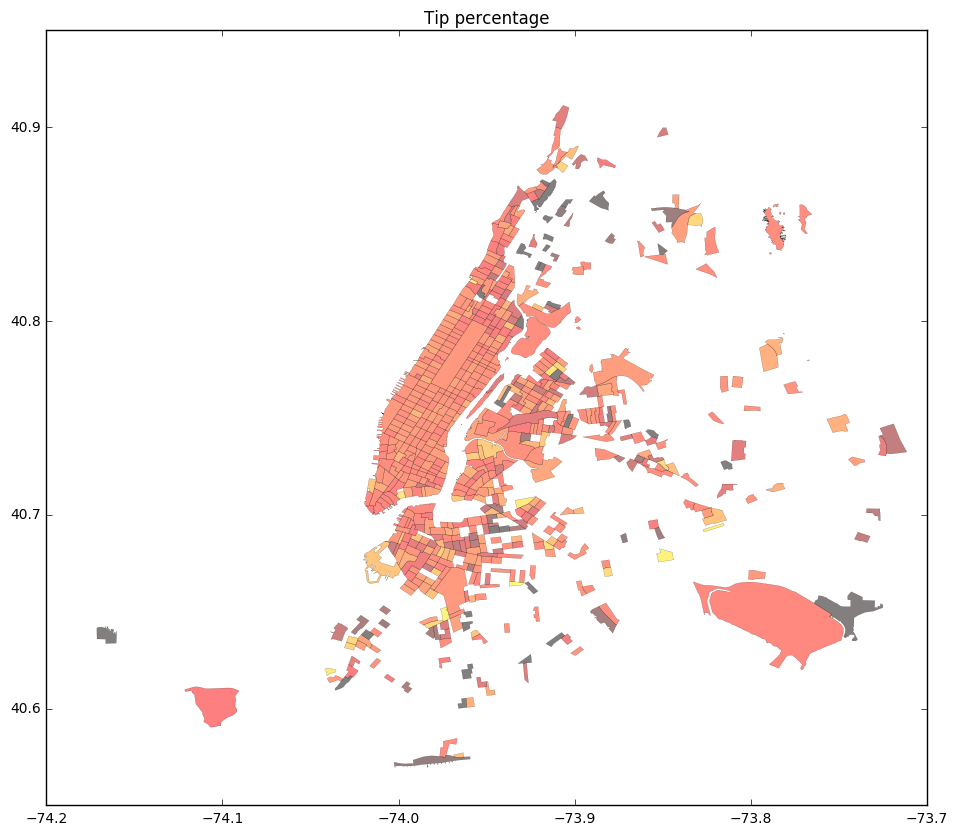

In [372]:
import matplotlib.pylab as plt
f = plt.figure(figsize=(25,10))
ax = f.add_subplot(121)
ct_shape_tip_clean.plot(column='tip_percentage', alpha=0.5, linewidth=0.1, ax=ax, cmap='hot')
ax.set_title("Tip percentage")
plt.legend()

## This is the heat map from amount low to high as from color black to yellow through red. 


---

## Import the Median age Data:

In [417]:
medianage = pd.read_csv("ttp1.csv")

In [418]:
medianage = medianage.iloc[:,(0,3)]

In [419]:
medianage.dropna(inplace = True)

In [420]:
tipmean.head()

,BoroCT2010,tip_percentage
0,,20.757676
1,1000201,25.384615
2,1000202,24.107143
3,1000600,19.136006
4,1000700,19.327208


In [421]:
medianage["BoroCT2010"] = medianage['Census Tract'].apply(lambda x: str(x)[4:-4])

In [426]:
medianage_merge = medianage.merge(tipmean, on = "BoroCT2010", how = "inner")

In [427]:
medianage_merge.head()

,Census Tract,Estimated typical (median) age of all people between 2010-2014.,BoroCT2010,tip_percentage
0,"36085017700, NY",47.0,5017700,17.921260
1,"36061024000, NY",47.0,1024000,20.370370
2,"36081024000, NY",34.0,1024000,20.370370
3,"36061009900, NY",33.0,1009900,21.974352
4,"36081019900, NY",35.0,1019900,20.652656


In [428]:
medianage_merge=medianage_merge.rename(columns = {'Estimated typical (median) age of all people between 2010-2014.':'age'})

In [430]:
medianage_merge.head()

,Census Tract,age,BoroCT2010,tip_percentage
0,"36085017700, NY",47.0,5017700,17.921260
1,"36061024000, NY",47.0,1024000,20.370370
2,"36081024000, NY",34.0,1024000,20.370370
3,"36061009900, NY",33.0,1009900,21.974352
4,"36081019900, NY",35.0,1019900,20.652656


In [433]:
medianage_merge_clean = medianage_merge.loc[medianage_merge.tip_percentage < 50]

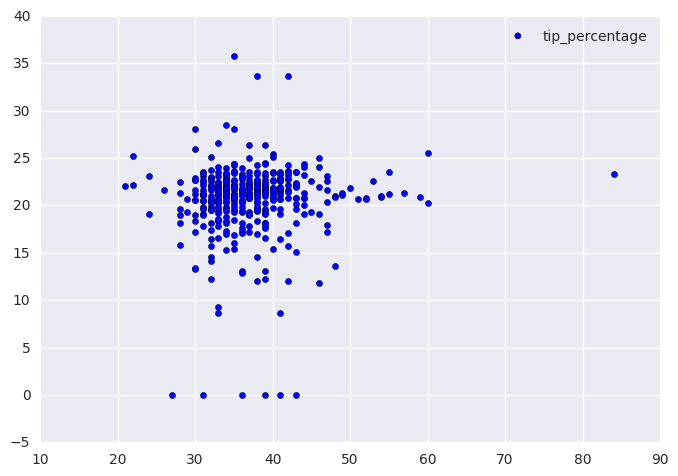

In [441]:
plt.scatter(medianage_merge_clean.age, medianage_merge_clean.tip_percentage)
plt.legend(loc = "best")

In [442]:
medianincome = pd.read_csv("ttp2.csv")

In [448]:
medianincome.head(10)

,Census Tract,FIPS Code,Formatted FIPS,Estimated per capita income between 2010-2014.
6,"36005050400, NY",3.600505e+10,3.600505e+10,83146.0
7,"36085022800, NY",3.608502e+10,3.608502e+10,69008.0
8,"36085029102, NY",3.608503e+10,3.608503e+10,33233.0
9,"36085019800, NY",3.608502e+10,3.608502e+10,42397.0
10,"36085022600, NY",3.608502e+10,3.608502e+10,35721.0
12,"36005051600, NY",3.600505e+10,3.600505e+10,42790.0
13,"36081091601, NY",3.608109e+10,3.608109e+10,39540.0
14,"36047005300, NY",3.604701e+10,3.604701e+10,39125.0
15,"36047070202, NY",3.604707e+10,3.604707e+10,32331.0
16,"36005043500, NY",3.600504e+10,3.600504e+10,14927.0


In [445]:
medianincome.dropna(inplace = True)

In [449]:
medianincome["BoroCT2010"] = medianincome['Census Tract'].apply(lambda x: str(x)[4:-4])

In [451]:
medianincome.columns

Index([u'Census Tract', u'FIPS Code', u'Formatted FIPS',
       u'Estimated per capita income between 2010-2014.', u'BoroCT2010'],
      dtype='object')

In [452]:
medianincome_merge = medianincome.merge(tipmean, on = "BoroCT2010", how = "inner")

In [453]:
medianincome_merge=medianincome_merge.rename(columns = {'Estimated per capita income between 2010-2014.':'income per capita'})

In [455]:
medianincome_merge.head()

,Census Tract,FIPS Code,Formatted FIPS,income per capita,BoroCT2010,tip_percentage
0,"36085017700, NY",3.608502e+10,3.608502e+10,53314.0,5017700,17.921260
1,"36061024000, NY",3.606102e+10,3.606102e+10,5171.0,1024000,20.370370
2,"36081024000, NY",3.608102e+10,3.608102e+10,18151.0,1024000,20.370370
3,"36061009900, NY",3.606101e+10,3.606101e+10,123604.0,1009900,21.974352
4,"36081019900, NY",3.608102e+10,3.608102e+10,15463.0,1019900,20.652656


In [456]:
medianincome_merge_clean = medianincome_merge.loc[medianincome_merge.tip_percentage < 50]

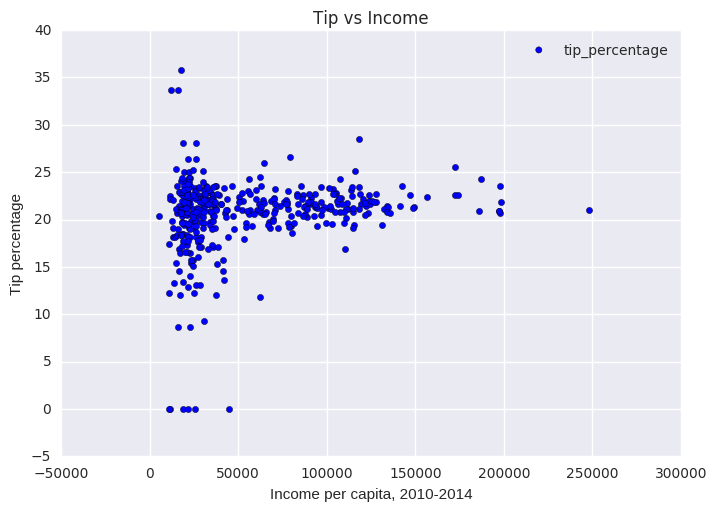

In [461]:
plt.scatter(medianincome_merge_clean["income per capita"], medianincome_merge_clean.tip_percentage)
plt.ylabel("Tip percentage")
plt.xlabel("Income per capita, 2010-2014")
plt.title("Tip vs Income")
plt.legend(loc = "best")
